# Convergence Testing: The Foundation of Reliable DFT Calculations

## Why This Notebook is Critical

**Convergence testing is the single most important step before any DFT property calculation.**

Without proper convergence testing:
- Your total energies are meaningless numbers
- Your lattice constants could be off by several percent
- Your band gaps are unreliable
- Your phonon frequencies may have wrong signs
- Your calculated phase transitions may not exist

### Learning Objectives

1. Understand why convergence testing is non-negotiable
2. Master ecutwfc (wavefunction cutoff) convergence testing
3. Master k-point mesh convergence testing
4. Learn smearing width convergence for metals
5. Perform combined (2D) convergence analysis
6. Understand force and stress convergence requirements
7. Store and reuse converged parameters

---

## 1. Why Convergence Testing is Non-Negotiable

### The Core Concept

A calculation is **converged** when increasing the accuracy parameter (cutoff, k-points, etc.) no longer changes the quantity of interest beyond a specified threshold.

### Key Principles

| Principle | Description |
|-----------|-------------|
| **Variational** | Total energy approaches the true value from above as basis improves |
| **Systematic** | Errors decrease monotonically with increasing accuracy |
| **Property-dependent** | Different properties require different convergence levels |
| **System-specific** | Converged values depend on elements and pseudopotentials |

### Standard Convergence Criteria

| Property | Typical Threshold | Stringent Threshold |
|----------|-------------------|--------------------|
| Total energy | 1 meV/atom | 0.1 meV/atom |
| Forces | 10 meV/Angstrom | 1 meV/Angstrom |
| Stress | 0.5 kbar | 0.1 kbar |
| Lattice constant | 0.01 Angstrom | 0.001 Angstrom |

### The Three Parameters We Must Converge

1. **ecutwfc**: Plane wave kinetic energy cutoff
2. **K-point mesh**: Brillouin zone sampling density
3. **Smearing width** (metals only): Fermi surface broadening

---

## 2. Setup and Helper Functions

First, let's set up our working environment and define all the functions we'll need.

In [1]:
# =============================================================================
# SETUP - Run this cell first (downloads pseudopotentials automatically)
# =============================================================================

import sys
import os
from pathlib import Path
from typing import Any, Dict, Optional

import numpy as np
import matplotlib.pyplot as plt
import json
import time
import re

from ase import Atoms
from ase.build import bulk
from ase.data import atomic_masses, atomic_numbers
from ase.io.espresso import write_espresso_in

_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))
else:
    raise FileNotFoundError("Cannot find workshop_setup.py. Run from the workshop root or notebooks_enhanced/")

from workshop_setup import *

# =============================================================================
# >>> STUDENT: MODIFY THIS SECTION FOR YOUR MATERIAL <<<
# =============================================================================

MATERIAL = 'Si'
STRUCTURE_TYPE = 'diamond'
LATTICE_A = 5.43

FUNCTIONAL = 'PBE'
# FUNCTIONAL = 'LDA'
# FUNCTIONAL = 'PBEsol'

# =============================================================================
# AUTOMATIC SETUP
# =============================================================================

atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))

pp_files = setup_pseudopotentials(elements, functional=FUNCTIONAL)
ecutwfc_sssp, ecutrho_sssp = get_recommended_cutoffs(elements, functional=FUNCTIONAL)
PSEUDO_DIR_FUNC = get_pseudo_dir(FUNCTIONAL)

# Backward-compatibility alias used by some cells below
PSEUDO_DIR = PSEUDO_DIR_FUNC

WORK_DIR = OUTPUT_DIR / '04_convergence'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

print(f"\n{'='*70}")
print(f"CONVERGENCE TESTING SETUP")
print(f"{'='*70}")
print(f"Material:       {MATERIAL} ({STRUCTURE_TYPE})")
print(f"Lattice:        {LATTICE_A} Å")
print(f"Functional:     {FUNCTIONAL}")
print(f"Pseudo dir:     {PSEUDO_DIR_FUNC}")
print(f"SSSP cutoffs:   ecutwfc={ecutwfc_sssp} Ry, ecutrho={ecutrho_sssp} Ry")
print(f"Working dir:    {WORK_DIR}")
print(f"{'='*70}")
print(f"\nPseudopotentials for {FUNCTIONAL}:")
for elem, path in pp_files.items():
    print(f"  {elem}: {path.name}")


# =============================================================================
# Backward-compatible helpers (so older cells still execute)
# =============================================================================

def generate_scf_input(prefix: str, ecutwfc: float, ecutrho: float,
                       kpoints, pseudo_dir,
                       celldm1=None,
                       conv_thr: float = 1.0e-8,
                       degauss: float = 0.01,
                       smearing: str = 'cold') -> str:
    """Generate a QE SCF input file text (QE 6.x compatible order/cards)."""

    ecutwfc = float(ecutwfc)
    ecutrho = float(ecutrho)
    conv_thr = float(conv_thr)
    degauss = float(degauss)

    if isinstance(kpoints, (list, tuple)):
        kpoints = tuple(int(k) for k in kpoints)

    pseudo_dir = Path(pseudo_dir)
    pseudo_dir_rel = os.path.relpath(pseudo_dir, WORK_DIR)

    species = sorted(set(atoms.get_chemical_symbols()))

    lines = []
    lines.append("&CONTROL")
    lines.append("  calculation = 'scf'")
    lines.append(f"  prefix = '{prefix}'")
    lines.append("  outdir = './tmp'")
    lines.append(f"  pseudo_dir = '{pseudo_dir_rel}'")
    lines.append("  verbosity = 'high'")
    lines.append("  tprnfor = .true.")
    lines.append("  tstress = .true.")
    lines.append("/")

    lines.append("&SYSTEM")
    lines.append("  ibrav = 0")
    lines.append(f"  nat = {len(atoms)}")
    lines.append(f"  ntyp = {len(species)}")
    lines.append(f"  ecutwfc = {ecutwfc}")
    lines.append(f"  ecutrho = {ecutrho}")
    lines.append("  occupations = 'smearing'")
    lines.append(f"  smearing = '{smearing}'")
    lines.append(f"  degauss = {degauss}")
    lines.append("/")

    lines.append("&ELECTRONS")
    lines.append(f"  conv_thr = {conv_thr}")
    lines.append("/")

    # QE expects cards in a specific order:
    # ATOMIC_SPECIES, ATOMIC_POSITIONS, K_POINTS, CELL_PARAMETERS
    lines.append("ATOMIC_SPECIES")
    for s in species:
        mass = float(atomic_masses[atomic_numbers[s]])
        pp = get_pseudopotential_filename(s, FUNCTIONAL)
        lines.append(f" {s} {mass:.6f} {pp}")

    lines.append("ATOMIC_POSITIONS angstrom")
    for s, p in zip(atoms.get_chemical_symbols(), atoms.get_positions()):
        lines.append(f" {s} {p[0]:.10f} {p[1]:.10f} {p[2]:.10f}")

    lines.append("K_POINTS automatic")
    lines.append(f" {kpoints[0]} {kpoints[1]} {kpoints[2]} 0 0 0")

    lines.append("CELL_PARAMETERS angstrom")
    for v in atoms.get_cell():
        lines.append(f" {v[0]:.12f} {v[1]:.12f} {v[2]:.12f}")

    lines.append("")
    return "\n".join(lines)


def run_calculation(input_file: Path, nprocs: int = None):
    """Backward-compatible wrapper around `run_qe`."""
    return run_qe(Path(input_file), executable='pw.x', nprocs=nprocs or NPROCS, use_mpi=True, timeout=1800)

PSEUDOPOTENTIAL SETUP - PBE
  ✓ Si: Si.pbe-n-rrkjus_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE

CONVERGENCE TESTING SETUP
Material:       Si (diamond)
Lattice:        5.43 Å
Functional:     PBE
Pseudo dir:     /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE
SSSP cutoffs:   ecutwfc=40 Ry, ecutrho=320 Ry
Working dir:    /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/04_convergence

Pseudopotentials for PBE:
  Si: Si.pbe-n-rrkjus_psl.1.0.0.UPF


/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### 2.1 Input File Generation Function

This function generates SCF input files with configurable parameters.

In [2]:
# =============================================================================
# MINIMAL INPUT FILE GENERATOR USING ASE
# =============================================================================

def create_scf_input(atoms, prefix, ecutwfc, kpts, work_dir):
    """
    Create QE SCF input using ASE.
    """
    input_file = work_dir / f'{prefix}.in'

    pseudopotentials = {}
    for elem in set(atoms.get_chemical_symbols()):
        pseudopotentials[elem] = get_pseudopotential_filename(elem, FUNCTIONAL)

    input_data = {
        'control': {
            'calculation': 'scf',
            'prefix': prefix,
            'outdir': './tmp',
            'pseudo_dir': str(PSEUDO_DIR_FUNC),
            'verbosity': 'high',
            'tprnfor': True,
            'tstress': True,
        },
        'system': {
            'ecutwfc': ecutwfc,
            'ecutrho': ecutwfc * 8,
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': 0.01,
        },
        'electrons': {
            'conv_thr': 1.0e-8,
        },
    }

    write_espresso_in(input_file, atoms, input_data=input_data,
                      pseudopotentials=pseudopotentials, kpts=kpts)
    return input_file


def parse_energy(output_text):
    """Extract total energy from QE output."""
    for line in output_text.split('\n'):
        if '!' in line and 'total energy' in line:
            match = re.search(r'=\s+([-\d.]+)\s+Ry', line)
            if match:
                return float(match.group(1)) * RY_TO_EV
    return None


print("Input generator and parser functions defined.")

Input generator and parser functions defined.


### 2.2 Output Parsing Function

This function extracts key quantities from pw.x output files.

In [3]:
# =============================================================================
# REFERENCE: Comprehensive QE output parser
# =============================================================================
# This parser extracts energy, forces, pressure, stress tensor, k-points, etc.
# The convergence cells below use simpler inline parsers, but this function
# is available if you need detailed output parsing for your own work.
# =============================================================================

def parse_output(output_text: str) -> dict:
    """
    Parse pw.x output to extract key quantities.
    
    Returns
    -------
    dict with: converged, energy_ry, volume_bohr3, pressure_kbar,
               total_force, nkpts_irreducible, max_force, forces, stress_tensor
    """
    results = {
        'converged': False,
        'energy_ry': None,
        'volume_bohr3': None,
        'pressure_kbar': None,
        'total_force': None,
        'nkpts_irreducible': None,
        'max_force': None,
        'forces': [],
        'stress_tensor': None,
        'scf_iterations': 0
    }
    
    results['converged'] = 'convergence has been achieved' in output_text
    
    iteration_matches = re.findall(r'iteration #\s*(\d+)', output_text)
    if iteration_matches:
        results['scf_iterations'] = int(iteration_matches[-1])
    
    lines = output_text.split('\n')
    stress_lines = []
    in_stress_block = False
    
    for i, line in enumerate(lines):
        if '!' in line and 'total energy' in line:
            match = re.search(r'=\s+([\d.E+-]+)\s+Ry', line)
            if match:
                results['energy_ry'] = float(match.group(1))
        
        if 'unit-cell volume' in line:
            match = re.search(r'=\s+([\d.]+)', line)
            if match:
                results['volume_bohr3'] = float(match.group(1))
        
        if 'number of k points' in line:
            match = re.search(r'=\s+(\d+)', line)
            if match:
                results['nkpts_irreducible'] = int(match.group(1))
        
        if 'total   stress' in line and 'P=' in line:
            match = re.search(r'P=\s*([\d.E+-]+)', line)
            if match:
                results['pressure_kbar'] = float(match.group(1))
            in_stress_block = True
            stress_lines = []
            continue
        
        if in_stress_block and len(stress_lines) < 3:
            stripped = line.strip()
            if stripped:
                stress_lines.append(stripped)
            if len(stress_lines) == 3:
                in_stress_block = False
                stress_tensor = np.zeros((3, 3))
                for j, sline in enumerate(stress_lines):
                    parts = sline.split()
                    if len(parts) >= 6:
                        stress_tensor[j] = [float(parts[3]), float(parts[4]), float(parts[5])]
                results['stress_tensor'] = stress_tensor
        
        if 'Total force' in line:
            match = re.search(r'Total force\s*=\s*([\d.]+)', line)
            if match:
                results['total_force'] = float(match.group(1))
        
        if 'atom' in line and 'force =' in line:
            match = re.search(r'force\s*=\s*([\d.E+-]+)\s+([\d.E+-]+)\s+([\d.E+-]+)', line)
            if match:
                fx, fy, fz = float(match.group(1)), float(match.group(2)), float(match.group(3))
                results['forces'].append([fx, fy, fz])
    
    if results['forces']:
        forces_array = np.array(results['forces'])
        force_magnitudes = np.sqrt(np.sum(forces_array**2, axis=1))
        results['max_force'] = float(np.max(force_magnitudes))
    
    return results


print("✓ parse_output() function defined (reference parser for detailed QE output analysis).")

✓ parse_output() function defined (reference parser for detailed QE output analysis).


### 2.3 Calculation Runner Function

This function executes pw.x and handles output.

In [4]:
# =============================================================================
# ECUTWFC CONVERGENCE TEST
# =============================================================================
# This runs real QE calculations to find the converged wavefunction cutoff.
# Convergence criterion: energy change < 1 meV/atom between steps.
# =============================================================================

def run_ecutwfc_convergence(atoms, kpts=(8,8,8), ecutwfc_values=None):
    """
    Run ecutwfc convergence test.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Structure to test
    kpts : tuple
        K-point mesh (fixed during test)
    ecutwfc_values : list
        Cutoff values to test (Ry)
    
    Returns
    -------
    dict : Convergence results
    """
    if ecutwfc_values is None:
        # Default: test from 20 to 100 Ry in steps of 10
        ecutwfc_values = [20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    n_atoms = len(atoms)
    energies = []
    
    print(f"\n{'='*60}")
    print(f"ECUTWFC CONVERGENCE TEST")
    print(f"K-points: {kpts}, Atoms: {n_atoms}")
    print(f"{'='*60}")
    print(f"{'ecutwfc (Ry)':<15} {'E (eV/atom)':<15} {'ΔE (meV/atom)':<15} {'Status'}")
    print(f"{'-'*60}")
    
    for ecutwfc in ecutwfc_values:
        prefix = f'conv_ecut_{int(ecutwfc)}'
        input_file = create_scf_input(atoms, prefix, ecutwfc, kpts, WORK_DIR)
        output, _, converged = run_qe(input_file, nprocs=NPROCS)
        
        energy = parse_energy(output)
        if energy is not None:
            e_per_atom = energy / n_atoms
            energies.append((ecutwfc, e_per_atom))
            
            if len(energies) > 1:
                delta = (e_per_atom - energies[-2][1]) * 1000  # meV
                status = "✓ converged" if abs(delta) < 1.0 else ""
            else:
                delta = float('nan')
                status = ""
            
            print(f"{ecutwfc:<15.0f} {e_per_atom:<15.6f} {delta:<15.3f} {status}")
        else:
            print(f"{ecutwfc:<15.0f} {'FAILED':<15} {'-':<15}")
    
    print(f"{'='*60}")
    
    # Find converged value
    for i in range(1, len(energies)):
        delta = abs(energies[i][1] - energies[i-1][1]) * 1000
        if delta < 1.0:
            print(f"\n✓ CONVERGED at ecutwfc = {energies[i][0]} Ry (ΔE < 1 meV/atom)")
            break
    
    return {
        'ecutwfc': [e[0] for e in energies],
        'energy_per_atom': [e[1] for e in energies],
    }


# To run the test (uncomment):
# results = run_ecutwfc_convergence(atoms)

print("Convergence test function defined.")
print("To run: results = run_ecutwfc_convergence(atoms)")

Convergence test function defined.
To run: results = run_ecutwfc_convergence(atoms)


### 2.4 Convergence Analysis Function

This function analyzes convergence of calculated values.

In [5]:
# =============================================================================
# REFERENCE: Convergence analysis helper
# =============================================================================
# This function can be used to analyze convergence of any parameter.
# The convergence cells below perform their own inline analysis.
# =============================================================================

def analyze_convergence(
    parameter_values,
    energies,
    threshold_mev_per_atom: float = 1.0,
    n_atoms: int = 2,
    reference_idx: int = -1
) -> dict:
    """
    Analyze convergence of total energy with respect to a parameter.
    
    Parameters
    ----------
    parameter_values : array-like
        Parameter values tested
    energies : array-like
        Corresponding total energies in Ry
    threshold_mev_per_atom : float
        Convergence threshold in meV/atom
    n_atoms : int
        Number of atoms in unit cell
    reference_idx : int
        Index of reference calculation (default: -1, most accurate)
    
    Returns
    -------
    dict with: delta_E_meV_per_atom, converged_value, converged_index, reference_energy
    """
    parameter_values = np.array(parameter_values)
    energies = np.array(energies)
    
    reference_energy = energies[reference_idx]
    delta_E = (energies - reference_energy) * RY_TO_MEV / n_atoms
    
    converged_value = None
    converged_index = None
    
    for i, de in enumerate(delta_E):
        if abs(de) <= threshold_mev_per_atom:
            converged_value = parameter_values[i]
            converged_index = i
            break
    
    return {
        'delta_E_meV_per_atom': delta_E,
        'converged_value': converged_value,
        'converged_index': converged_index,
        'reference_energy': reference_energy,
        'threshold_mev_per_atom': threshold_mev_per_atom
    }


print("✓ analyze_convergence() function defined (reusable convergence analysis).")

✓ analyze_convergence() function defined (reusable convergence analysis).


### 2.5 Plotting Function

This function creates publication-quality convergence plots.

In [6]:
# =============================================================================
# REFERENCE: Reusable convergence plotting function
# =============================================================================
# This function creates publication-quality convergence plots.
# The convergence sections below create their own inline plots, but this
# function is available for your own convergence studies.
# =============================================================================

def plot_convergence(
    parameter_values,
    energies,
    times=None,
    parameter_name: str = 'Parameter',
    parameter_unit: str = '',
    threshold_mev: float = 1.0,
    n_atoms: int = 2,
    save_path=None,
    title=None
):
    """
    Create comprehensive convergence plots (energy, convergence, cost).
    
    Parameters
    ----------
    parameter_values : array-like
        Parameter values tested
    energies : array-like
        Total energies in Ry
    times : array-like, optional
        Calculation times in seconds
    parameter_name : str
        Name of the parameter for labels
    parameter_unit : str
        Unit of the parameter
    threshold_mev : float
        Convergence threshold in meV/atom
    n_atoms : int
        Number of atoms in unit cell
    save_path : Path, optional
        Path to save figure
    title : str, optional
        Custom figure title
    
    Returns
    -------
    matplotlib.figure.Figure
    """
    parameter_values = np.array(parameter_values)
    energies = np.array(energies)
    
    E_ref = energies[-1]
    delta_E = (energies - E_ref) * RY_TO_MEV / n_atoms
    
    converged_idx = None
    for i, de in enumerate(delta_E):
        if abs(de) <= threshold_mev:
            converged_idx = i
            break
    
    n_plots = 3 if times is not None else 2
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 4))
    
    unit_str = f" ({parameter_unit})" if parameter_unit else ""
    
    ax1 = axes[0]
    ax1.plot(parameter_values, energies, 'bo-', markersize=8, linewidth=2)
    ax1.set_xlabel(f'{parameter_name}{unit_str}', fontsize=12)
    ax1.set_ylabel('Total Energy (Ry)', fontsize=12)
    ax1.set_title('Total Energy', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    valid_mask = np.abs(delta_E[:-1]) > 1e-10
    if np.any(valid_mask):
        ax2.semilogy(parameter_values[:-1][valid_mask], np.abs(delta_E[:-1][valid_mask]), 
                     'ro-', markersize=8, linewidth=2)
    ax2.axhline(y=threshold_mev, color='g', linestyle='--', linewidth=2,
                label=f'Threshold = {threshold_mev} meV/atom')
    if converged_idx is not None:
        ax2.axvline(x=parameter_values[converged_idx], color='b', linestyle=':', 
                    alpha=0.7, linewidth=2,
                    label=f'Converged at {parameter_values[converged_idx]}{unit_str}')
    ax2.set_xlabel(f'{parameter_name}{unit_str}', fontsize=12)
    ax2.set_ylabel('|dE| (meV/atom)', fontsize=12)
    ax2.set_title('Energy Convergence', fontsize=14)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    if times is not None:
        ax3 = axes[2]
        ax3.bar(range(len(times)), times, color='steelblue', alpha=0.7)
        ax3.set_xticks(range(len(times)))
        ax3.set_xticklabels([f'{p:.0f}' for p in parameter_values], rotation=45)
        ax3.set_xlabel(f'{parameter_name}{unit_str}', fontsize=12)
        ax3.set_ylabel('Wall Time (s)', fontsize=12)
        ax3.set_title('Computational Cost', fontsize=14)
        ax3.grid(True, alpha=0.3, axis='y')
    
    if title:
        fig.suptitle(title, fontsize=16, y=1.02)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig


print("✓ plot_convergence() function defined (reusable plotting for convergence studies).")

✓ plot_convergence() function defined (reusable plotting for convergence studies).


---

## 3. Ecutwfc (Wavefunction Cutoff) Convergence

### Theoretical Background

In plane-wave DFT, wavefunctions are expanded as:

$$\psi_n(\mathbf{r}) = \sum_{\mathbf{G}} c_{n,\mathbf{G}} e^{i(\mathbf{k}+\mathbf{G})\cdot\mathbf{r}}$$

where $\mathbf{G}$ are reciprocal lattice vectors. The cutoff determines which plane waves to include:

$$\frac{\hbar^2}{2m}|\mathbf{k}+\mathbf{G}|^2 < E_{\text{cut}}$$

### Key Points

- **ecutwfc** is the kinetic energy cutoff for wavefunctions (in Ry)
- **ecutrho** is the cutoff for charge density (typically 4x ecutwfc for NC, 8-12x for PAW/USPP)
- Higher cutoff = more plane waves = more accurate but slower
- Convergence is **variational**: energy approaches true value from above

In [7]:
# Define ecutwfc convergence test parameters
# Use a small set by default so the workshop runs in a reasonable time.
FAST_MODE = True

ECUTRHO_FACTOR = 8  # For PAW/US pseudopotentials (typical)
KPOINTS_FIXED = (6, 6, 6)  # Fixed k-point grid for cutoff tests

if FAST_MODE:
    ECUTWFC_VALUES = [20, 30, 40, 50, 60]
else:
    ECUTWFC_VALUES = [15, 20, 25, 30, 35, 40, 45, 50, 60, 70]

print("Ecutwfc Convergence Test Parameters")
print("=" * 60)
print(f"Material: {MATERIAL} ({STRUCTURE_TYPE})")
print(f"FAST_MODE: {FAST_MODE}")
print(f"ecutwfc values: {ECUTWFC_VALUES} Ry")
print(f"ecutrho = {ECUTRHO_FACTOR} x ecutwfc")
print(f"K-points (fixed): {KPOINTS_FIXED}")
print(f"SSSP recommended ecutwfc: {ecutwfc_sssp} Ry")
print(f"\nNote: Convergence should occur near the SSSP recommended value.")

Ecutwfc Convergence Test Parameters
Material: Si (diamond)
FAST_MODE: True
ecutwfc values: [20, 30, 40, 50, 60] Ry
ecutrho = 8 x ecutwfc
K-points (fixed): (6, 6, 6)
SSSP recommended ecutwfc: 40 Ry

Note: Convergence should occur near the SSSP recommended value.


In [8]:
# =============================================================================
# RUN ACTUAL ECUTWFC CONVERGENCE TEST
# =============================================================================
# This runs REAL QE calculations for the material defined in the setup cell.
# We systematically increase ecutwfc and look for energy convergence.
# =============================================================================

from datetime import datetime

# Create timestamped working directory
WORK_DIR = OUTPUT_DIR / f'04_conv_{MATERIAL}_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

n_atoms = len(atoms)
ecutwfc_converged = None


def _parse_total_energy_ev(output_text: str):
    for line in output_text.split('\n'):
        if '!' in line and 'total energy' in line:
            match = re.search(r'=\s+([-\d.]+)\s+Ry', line)
            if match:
                return float(match.group(1)) * RY_TO_EV
    return None


def _parse_total_force(output_text: str):
    for line in output_text.split('\n'):
        if 'Total force' in line:
            match = re.search(r'Total force\s*=\s*([\d.E+-]+)', line)
            if match:
                return float(match.group(1))
    return None


def _parse_pressure_kbar(output_text: str):
    for line in output_text.split('\n'):
        if 'P=' in line and 'stress' in line:
            match = re.search(r'P=\s*([\d.E+-]+)', line)
            if match:
                return float(match.group(1))
    match = re.search(r'P=\s*([\d.E+-]+)', output_text)
    if match:
        return float(match.group(1))
    return None


print("=" * 70)
print(f"ECUTWFC CONVERGENCE TEST: {MATERIAL}")
print("=" * 70)
print(f"K-points (fixed): {KPOINTS_FIXED}")
print(f"Testing ecutwfc: {ECUTWFC_VALUES} Ry")
print(f"SSSP recommended: {ecutwfc_sssp} Ry")
print("=" * 70)

pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in elements}

ecutwfc_results = []
print(f"\n{'ecutwfc':<10} {'E (eV/atom)':<16} {'ΔE (meV/atom)':<16} {'P (kbar)':<10} {'|F| (Ry/Bohr)':<16} {'Status'}")
print("-" * 90)

mat_lower = MATERIAL.lower()
for ecutwfc in ECUTWFC_VALUES:
    prefix = f'{mat_lower}_ecut_{int(ecutwfc)}'
    input_file = WORK_DIR / f'{prefix}.in'

    input_data = {
        'control': {
            'calculation': 'scf',
            'prefix': prefix,
            'outdir': './tmp',
            'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
            'tstress': True,
            'tprnfor': True,
        },
        'system': {
            'ecutwfc': ecutwfc,
            'ecutrho': ecutwfc * ECUTRHO_FACTOR,
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': 0.01,
        },
        'electrons': {'conv_thr': 1.0e-8},
    }

    write_espresso_in(
        input_file,
        atoms,
        input_data=input_data,
        pseudopotentials=pseudopotentials,
        kpts=KPOINTS_FIXED,
    )

    output, elapsed, converged = run_qe(input_file, nprocs=NPROCS, timeout=1800)

    energy = _parse_total_energy_ev(output)
    total_force = _parse_total_force(output)
    pressure_kbar = _parse_pressure_kbar(output)

    if energy is not None and converged:
        e_per_atom = energy / n_atoms

        if len(ecutwfc_results) > 0:
            prev_e = ecutwfc_results[-1].get('energy_ev_per_atom')
            delta = None if prev_e is None else (e_per_atom - prev_e) * 1000
            status = "✓ CONVERGED" if (delta is not None and abs(delta) < 1.0) else ""
            if ecutwfc_converged is None and delta is not None and abs(delta) < 1.0:
                ecutwfc_converged = ecutwfc
        else:
            delta = None
            status = ""

        ecutwfc_results.append({
            'ecutwfc': ecutwfc,
            'energy_ev_per_atom': e_per_atom,
            'delta_mev_per_atom': delta,
            'time_s': elapsed,
            'converged': True,
            'total_force': total_force,
            'pressure_kbar': pressure_kbar,
        })

        p_str = f"{pressure_kbar:.2f}" if pressure_kbar is not None else 'N/A'
        f_str = f"{total_force:.6f}" if total_force is not None else 'N/A'
        d_str = f"{delta:+.2f}" if delta is not None else '---'
        print(f"{ecutwfc:<10} {e_per_atom:<16.6f} {d_str:<16} {p_str:<10} {f_str:<16} {status}")
    else:
        ecutwfc_results.append({
            'ecutwfc': ecutwfc,
            'energy_ev_per_atom': None,
            'delta_mev_per_atom': None,
            'time_s': elapsed,
            'converged': False,
            'total_force': None,
            'pressure_kbar': None,
        })
        print(f"{ecutwfc:<10} {'FAILED':<16} {'-':<16} {'-':<10} {'-':<16} ")

print("-" * 90)

if ecutwfc_converged is None:
    successful = [r for r in ecutwfc_results if r.get('converged') and r.get('energy_ev_per_atom') is not None]
    if successful:
        ecutwfc_converged = successful[-1]['ecutwfc']
        print(f"\n⚠ No ΔE<1 meV/atom point found; using highest tested: {ecutwfc_converged} Ry")
    else:
        ecutwfc_converged = 60
        print(f"\n⚠ No successful points; using fallback: {ecutwfc_converged} Ry")
else:
    print(f"\n✓ CONVERGED ecutwfc = {ecutwfc_converged} Ry")
    print(f"  Recommended (with margin): {ecutwfc_converged + 5} Ry")

# Store for JSON export
ECUTWFC_CONVERGED = ecutwfc_converged

ECUTWFC CONVERGENCE TEST: Si
K-points (fixed): (6, 6, 6)
Testing ecutwfc: [20, 30, 40, 50, 60] Ry
SSSP recommended: 40 Ry

ecutwfc    E (eV/atom)      ΔE (meV/atom)    P (kbar)   |F| (Ry/Bohr)    Status
------------------------------------------------------------------------------------------
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_ecut_20.in


  ✓ Converged in 12.2s
20         -155.349818      ---              19.30      0.000000         
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_ecut_30.in


  ✓ Converged in 17.2s
30         -155.362133      -12.32           20.76      0.000000         
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_ecut_40.in


  ✓ Converged in 22.7s
40         -155.362987      -0.85            20.88      0.000000         ✓ CONVERGED
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_ecut_50.in


  ✓ Converged in 25.5s
50         -155.363627      -0.64            20.91      0.000000         ✓ CONVERGED
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_ecut_60.in


  ✓ Converged in 28.8s
60         -155.363764      -0.14            20.96      0.000000         ✓ CONVERGED
------------------------------------------------------------------------------------------

✓ CONVERGED ecutwfc = 40 Ry
  Recommended (with margin): 45 Ry


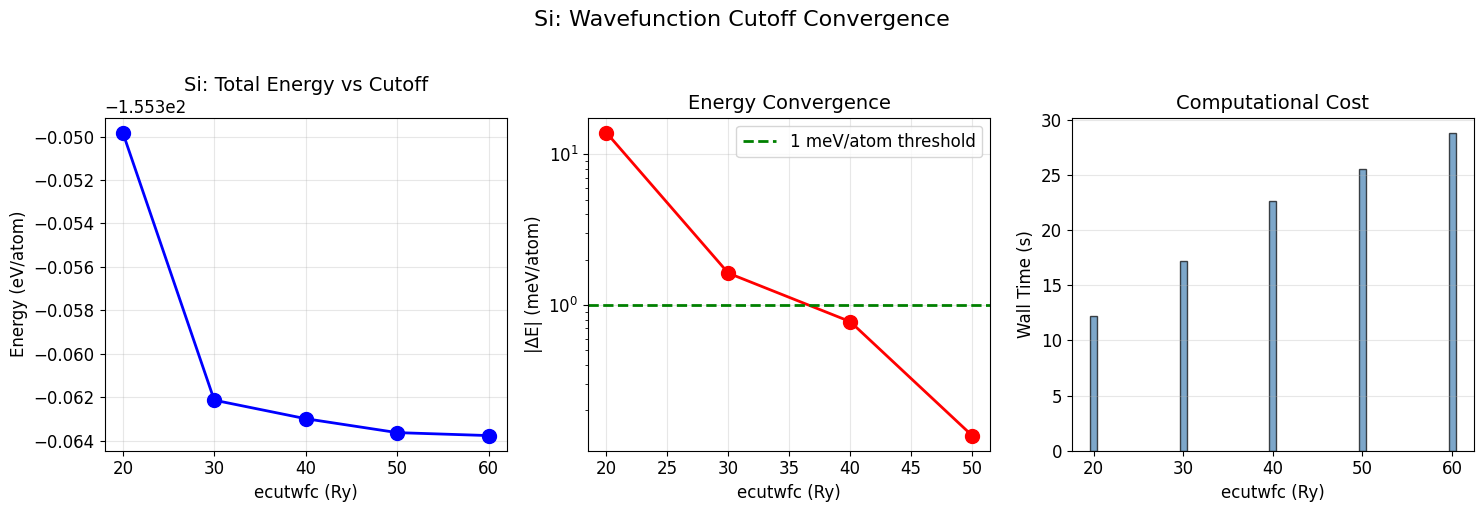


✓ Figure saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/04_conv_Si_20260206_003758/Si_ecutwfc_convergence.png


In [9]:
# Plot ecutwfc convergence (using results from the run above)

ecut_ok = [r for r in ecutwfc_results if r.get('converged') and r.get('energy_ev_per_atom') is not None]

if len(ecut_ok) >= 2:
    ecutwfc_arr = np.array([r['ecutwfc'] for r in ecut_ok])
    energy_arr = np.array([r['energy_ev_per_atom'] for r in ecut_ok])
    time_arr = np.array([r['time_s'] for r in ecut_ok])

    E_ref = energy_arr[-1]
    delta_E = (energy_arr - E_ref) * 1000  # meV/atom

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax1.plot(ecutwfc_arr, energy_arr, 'bo-', markersize=10, linewidth=2)
    ax1.set_xlabel('ecutwfc (Ry)', fontsize=12)
    ax1.set_ylabel('Energy (eV/atom)', fontsize=12)
    ax1.set_title(f'{MATERIAL}: Total Energy vs Cutoff', fontsize=14)
    ax1.grid(True, alpha=0.3)

    ax2 = axes[1]
    valid = np.abs(delta_E[:-1]) > 1e-6
    if np.any(valid):
        ax2.semilogy(ecutwfc_arr[:-1][valid], np.abs(delta_E[:-1][valid]), 'ro-', markersize=10, linewidth=2)
    ax2.axhline(y=1.0, color='g', linestyle='--', linewidth=2, label='1 meV/atom threshold')
    ax2.set_xlabel('ecutwfc (Ry)', fontsize=12)
    ax2.set_ylabel('|ΔE| (meV/atom)', fontsize=12)
    ax2.set_title('Energy Convergence', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = axes[2]
    ax3.bar(ecutwfc_arr, time_arr, color='steelblue', alpha=0.7, edgecolor='black')
    ax3.set_xlabel('ecutwfc (Ry)', fontsize=12)
    ax3.set_ylabel('Wall Time (s)', fontsize=12)
    ax3.set_title('Computational Cost', fontsize=14)
    ax3.grid(True, alpha=0.3, axis='y')

    plt.suptitle(f'{MATERIAL}: Wavefunction Cutoff Convergence', fontsize=16, y=1.02)
    plt.tight_layout()

    fig_path = WORK_DIR / f'{MATERIAL}_ecutwfc_convergence.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Figure saved: {fig_path}")
else:
    print("⚠ Not enough converged ecutwfc points to plot.")

# Provide backward-compatible analysis dict for later cells
conv_analysis = {
    'converged_value': ecutwfc_converged,
    'threshold_mev_per_atom': 1.0,
}

In [10]:
# Quick summary of ecutwfc convergence
print(f"Ecutwfc convergence summary for {MATERIAL}:")
print(f"  Converged at: {ecutwfc_converged} Ry")
print(f"  Recommended (with 5 Ry margin): {ecutwfc_converged + 5} Ry")
print(f"  SSSP recommended: {ecutwfc_sssp} Ry")
print(f"\nConvergence {'achieved ✓' if any(r.get('delta_mev_per_atom') is not None and abs(r['delta_mev_per_atom']) < 1.0 for r in ecutwfc_results) else 'not reached within tested range ⚠'}")

Ecutwfc convergence summary for Si:
  Converged at: 40 Ry
  Recommended (with 5 Ry margin): 45 Ry
  SSSP recommended: 40 Ry

Convergence achieved ✓


---

## 4. K-point Convergence

### Theoretical Background

Many physical quantities require integration over the Brillouin zone:

$$\bar{f} = \frac{1}{V_{BZ}} \int_{BZ} f(\mathbf{k}) d\mathbf{k}$$

This integral is approximated by a discrete sum over k-points:

$$\bar{f} \approx \sum_i w_i f(\mathbf{k}_i)$$

### Monkhorst-Pack Grid

The standard method uses a uniform grid of $n_1 \times n_2 \times n_3$ points. For cubic systems, we typically use $n \times n \times n$.

### Key Points

- Symmetry operations reduce the number of unique k-points
- Metals require denser k-grids than semiconductors/insulators
- K-point density should match cell size (larger cell = fewer k-points needed)

In [11]:
# K-point convergence test: use the converged ecutwfc + safety margin
ECUTWFC_CONVERGED = ecutwfc_converged + 5
ECUTRHO_CONVERGED = ECUTWFC_CONVERGED * ECUTRHO_FACTOR

# Define k-point grids to test
if FAST_MODE:
    KPOINT_GRIDS = [4, 6, 8, 10, 12]
else:
    KPOINT_GRIDS = [2, 4, 6, 8, 10, 12, 14]

print("K-point Convergence Test Parameters")
print("=" * 60)
print(f"Material: {MATERIAL}")
print(f"FAST_MODE: {FAST_MODE}")
print(f"K-grids to test: {KPOINT_GRIDS}")
print(f"ecutwfc (fixed): {ECUTWFC_CONVERGED} Ry")
print(f"ecutrho (fixed): {ECUTRHO_CONVERGED} Ry")

K-point Convergence Test Parameters
Material: Si
FAST_MODE: True
K-grids to test: [4, 6, 8, 10, 12]
ecutwfc (fixed): 45 Ry
ecutrho (fixed): 360 Ry


In [12]:
# =============================================================================
# RUN ACTUAL K-POINT CONVERGENCE TEST
# =============================================================================

pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in elements}

kgrid_converged = None

print("\n" + "=" * 70)
print(f"K-POINT CONVERGENCE TEST: {MATERIAL}")
print("=" * 70)
print(f"ecutwfc (fixed): {ECUTWFC_CONVERGED} Ry")
print(f"Testing k-grids: {KPOINT_GRIDS}")
print("=" * 70)

kpoint_results = []
print(f"\n{'K-grid':<12} {'E (eV/atom)':<16} {'ΔE (meV/atom)':<16} {'P (kbar)':<10} {'|F| (Ry/Bohr)':<16} {'Status'}")
print("-" * 90)

for k in KPOINT_GRIDS:
    kpts = (k, k, k)
    prefix = f'{mat_lower}_k{k}'
    input_file = WORK_DIR / f'{prefix}.in'

    input_data = {
        'control': {
            'calculation': 'scf',
            'prefix': prefix,
            'outdir': './tmp',
            'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
            'tstress': True,
            'tprnfor': True,
        },
        'system': {
            'ecutwfc': ECUTWFC_CONVERGED,
            'ecutrho': ECUTRHO_CONVERGED,
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': 0.01,
        },
        'electrons': {'conv_thr': 1.0e-8},
    }

    write_espresso_in(
        input_file,
        atoms,
        input_data=input_data,
        pseudopotentials=pseudopotentials,
        kpts=kpts,
    )

    output, elapsed, converged = run_qe(input_file, nprocs=NPROCS, timeout=1800)

    energy = _parse_total_energy_ev(output)
    total_force = _parse_total_force(output)
    pressure_kbar = _parse_pressure_kbar(output)

    if energy is not None and converged:
        e_per_atom = energy / n_atoms

        if len(kpoint_results) > 0 and kpoint_results[-1].get('energy_ev_per_atom') is not None:
            prev_e = kpoint_results[-1]['energy_ev_per_atom']
            delta = (e_per_atom - prev_e) * 1000
            status = "✓ CONVERGED" if abs(delta) < 1.0 else ""
            if kgrid_converged is None and abs(delta) < 1.0:
                kgrid_converged = k
        else:
            delta = None
            status = ""

        kpoint_results.append({
            'kgrid': k,
            'energy_ev_per_atom': e_per_atom,
            'delta_mev_per_atom': delta,
            'time_s': elapsed,
            'converged': True,
            'total_force': total_force,
            'pressure_kbar': pressure_kbar,
        })

        p_str = f"{pressure_kbar:.2f}" if pressure_kbar is not None else 'N/A'
        f_str = f"{total_force:.6f}" if total_force is not None else 'N/A'
        d_str = f"{delta:+.2f}" if delta is not None else '---'
        print(f"{k}x{k}x{k:<6} {e_per_atom:<16.6f} {d_str:<16} {p_str:<10} {f_str:<16} {status}")
    else:
        kpoint_results.append({
            'kgrid': k,
            'energy_ev_per_atom': None,
            'delta_mev_per_atom': None,
            'time_s': elapsed,
            'converged': False,
            'total_force': None,
            'pressure_kbar': None,
        })
        print(f"{k}x{k}x{k:<6} {'FAILED':<16} {'-':<16} {'-':<10} {'-':<16}")

print("-" * 90)

if kgrid_converged is None:
    successful = [r for r in kpoint_results if r.get('converged') and r.get('energy_ev_per_atom') is not None]
    if successful:
        kgrid_converged = successful[-1]['kgrid']
        print(f"\n⚠ No ΔE<1 meV/atom point found; using highest tested: {kgrid_converged}x{kgrid_converged}x{kgrid_converged}")
    else:
        kgrid_converged = 8
        print(f"\n⚠ No successful points; using fallback: {kgrid_converged}x{kgrid_converged}x{kgrid_converged}")
else:
    print(f"\n✓ CONVERGED k-grid = {kgrid_converged}x{kgrid_converged}x{kgrid_converged}")
    print(f"  Recommended (with margin): {kgrid_converged + 2}x{kgrid_converged + 2}x{kgrid_converged + 2}")


K-POINT CONVERGENCE TEST: Si
ecutwfc (fixed): 45 Ry
Testing k-grids: [4, 6, 8, 10, 12]

K-grid       E (eV/atom)      ΔE (meV/atom)    P (kbar)   |F| (Ry/Bohr)    Status
------------------------------------------------------------------------------------------
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_k4.in


  ✓ Converged in 17.2s
4x4x4      -155.280904      ---              26.53      0.000000         
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_k6.in


  ✓ Converged in 21.5s
6x6x6      -155.363357      -82.45           20.84      0.000000         
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_k8.in


  ✓ Converged in 28.6s
8x8x8      -155.373286      -9.93            20.21      0.000000         
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_k10.in


  ✓ Converged in 42.5s
10x10x10     -155.374900      -1.61            20.13      0.000000         
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_k12.in


  ✓ Converged in 67.7s
12x12x12     -155.375253      -0.35            20.11      0.000000         ✓ CONVERGED
------------------------------------------------------------------------------------------

✓ CONVERGED k-grid = 12x12x12
  Recommended (with margin): 14x14x14


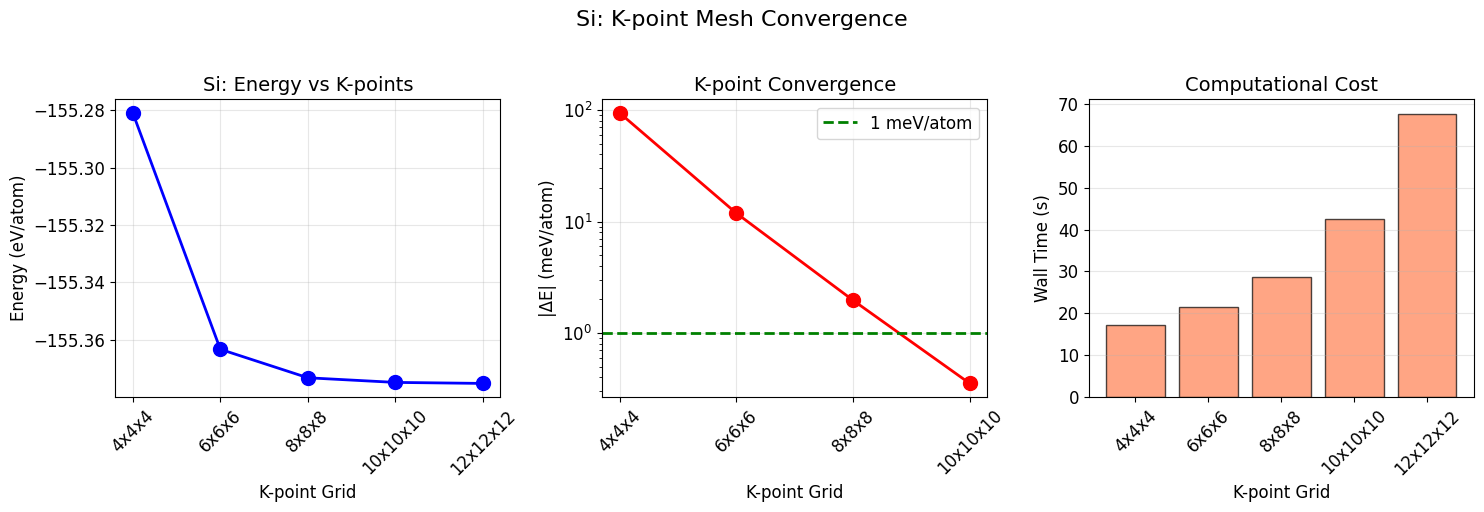


✓ Figure saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/04_conv_Si_20260206_003758/Si_kpoint_convergence.png


In [13]:
# Plot k-point convergence (using results from the run above)

kpt_ok = [r for r in kpoint_results if r.get('converged') and r.get('energy_ev_per_atom') is not None]

if len(kpt_ok) >= 2:
    kgrid_arr = np.array([r['kgrid'] for r in kpt_ok])
    energy_kpt_arr = np.array([r['energy_ev_per_atom'] for r in kpt_ok])
    time_kpt_arr = np.array([r['time_s'] for r in kpt_ok])

    E_ref_kpt = energy_kpt_arr[-1]
    delta_E_kpt = (energy_kpt_arr - E_ref_kpt) * 1000

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    kgrid_labels = [f'{k}x{k}x{k}' for k in kgrid_arr]

    ax1 = axes[0]
    ax1.plot(range(len(kgrid_arr)), energy_kpt_arr, 'bo-', markersize=10, linewidth=2)
    ax1.set_xticks(range(len(kgrid_arr)))
    ax1.set_xticklabels(kgrid_labels, rotation=45)
    ax1.set_xlabel('K-point Grid', fontsize=12)
    ax1.set_ylabel('Energy (eV/atom)', fontsize=12)
    ax1.set_title(f'{MATERIAL}: Energy vs K-points', fontsize=14)
    ax1.grid(True, alpha=0.3)

    ax2 = axes[1]
    valid_kpt = np.abs(delta_E_kpt[:-1]) > 1e-6
    if np.any(valid_kpt):
        ax2.semilogy(range(len(kgrid_arr)-1), np.abs(delta_E_kpt[:-1]), 'ro-', markersize=10, linewidth=2)
    ax2.axhline(y=1.0, color='g', linestyle='--', linewidth=2, label='1 meV/atom')
    ax2.set_xticks(range(len(kgrid_arr)-1))
    ax2.set_xticklabels(kgrid_labels[:-1], rotation=45)
    ax2.set_xlabel('K-point Grid', fontsize=12)
    ax2.set_ylabel('|ΔE| (meV/atom)', fontsize=12)
    ax2.set_title('K-point Convergence', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = axes[2]
    ax3.bar(range(len(kgrid_arr)), time_kpt_arr, color='coral', alpha=0.7, edgecolor='black')
    ax3.set_xticks(range(len(kgrid_arr)))
    ax3.set_xticklabels(kgrid_labels, rotation=45)
    ax3.set_xlabel('K-point Grid', fontsize=12)
    ax3.set_ylabel('Wall Time (s)', fontsize=12)
    ax3.set_title('Computational Cost', fontsize=14)
    ax3.grid(True, alpha=0.3, axis='y')

    plt.suptitle(f'{MATERIAL}: K-point Mesh Convergence', fontsize=16, y=1.02)
    plt.tight_layout()

    fig_path = WORK_DIR / f'{MATERIAL}_kpoint_convergence.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Figure saved: {fig_path}")
else:
    print("⚠ Not enough converged k-point runs to plot.")

kpt_conv_analysis = {
    'converged_value': kgrid_converged,
    'threshold_mev_per_atom': 1.0,
}

In [14]:
# Quick summary of k-point convergence
print(f"K-point convergence summary for {MATERIAL}:")
print(f"  Converged at: {kgrid_converged}x{kgrid_converged}x{kgrid_converged}")
print(f"  Recommended (with +2 margin): {kgrid_converged+2}x{kgrid_converged+2}x{kgrid_converged+2}")
print(f"\nConvergence {'achieved ✓' if any(r.get('delta_mev_per_atom') is not None and abs(r['delta_mev_per_atom']) < 1.0 for r in kpoint_results) else 'not reached within tested range ⚠'}")

K-point convergence summary for Si:
  Converged at: 12x12x12
  Recommended (with +2 margin): 14x14x14

Convergence achieved ✓


---

## 5. Smearing Width Convergence

### Why Smearing Matters

In DFT, we integrate over occupied electronic states. At the Fermi level:

- **Metals**: Sharp discontinuity in occupation → k-point integration is difficult → **smearing is essential**
- **Semiconductors/Insulators**: Clear band gap → occupation is well-defined → smearing is used only for numerical convenience

### Types of Smearing

| Type | QE keyword | Description | Best For |
|------|------------|-------------|----------|
| Gaussian | `gaussian` | Simple Gaussian broadening | Quick tests |
| Methfessel-Paxton | `mp` | Higher-order corrections | Total energies |
| Marzari-Vanderbilt | `mv` or `cold` | Optimized for forces | Forces, phonons |
| Fermi-Dirac | `fd` | Physical thermal occupation | Finite-T studies |

### The Convergence Challenge

- **Large degauss**: Easy SCF convergence but introduces error in total energy
- **Small degauss**: More accurate but harder to converge, needs more k-points
- **Goal**: Find the smallest degauss that gives converged energy with your k-mesh

### What Should You Do for Your Material?

| Material Type | Action |
|--------------|--------|
| **Metal** (Al, Cu, Fe, ...) | Smearing test is **mandatory** — results are very sensitive to degauss |
| **Semiconductor** (Si, GaAs, ...) | Smearing is used for numerical stability; effect is small but test anyway |
| **Insulator** (MgO, NaCl, ...) | Can use `occupations = 'fixed'` or small smearing for safety |
| **Unknown material** | Always run the smearing test — it costs little and reveals if your material is metallic |

**We demonstrate the smearing test on our current material (Si).** Since Si is a semiconductor, you will see that different degauss values produce nearly identical energies. For a metal, the differences would be much larger and this test becomes critical.

In [15]:
# =============================================================================
# Smearing Width Convergence - Using the SAME material as all other tests
# =============================================================================
# We test smearing on our main material (Si). For a semiconductor like Si,
# the effect is small — but running this test teaches you the workflow.
# For metals (Al, Cu, Fe, etc.), this test is CRITICAL.
# =============================================================================

# Use the same converged parameters from the ecutwfc/k-point tests
ECUTWFC_SMEAR = ECUTWFC_CONVERGED
ECUTRHO_SMEAR = ECUTRHO_CONVERGED
KGRID_SMEAR = (kgrid_converged, kgrid_converged, kgrid_converged)

# Smearing values to test (Ry)
if FAST_MODE:
    DEGAUSS_VALUES = [0.005, 0.01, 0.02, 0.04]
else:
    DEGAUSS_VALUES = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]

print("Smearing Width Convergence Test Parameters")
print("=" * 60)
print(f"Material: {MATERIAL} ({STRUCTURE_TYPE})")
print(f"FAST_MODE: {FAST_MODE}")
print(f"degauss values (Ry): {DEGAUSS_VALUES}")
print(f"ecutwfc: {ECUTWFC_SMEAR} Ry")
print(f"k-grid: {KGRID_SMEAR[0]}x{KGRID_SMEAR[1]}x{KGRID_SMEAR[2]}")
print("=" * 60)
print(f"\nNote: {MATERIAL} is a semiconductor, so smearing should have")
print(f"minimal effect. For metals, energy differences can be ~10-100 meV/atom.")

Smearing Width Convergence Test Parameters
Material: Si (diamond)
FAST_MODE: True
degauss values (Ry): [0.005, 0.01, 0.02, 0.04]
ecutwfc: 45 Ry
k-grid: 12x12x12

Note: Si is a semiconductor, so smearing should have
minimal effect. For metals, energy differences can be ~10-100 meV/atom.


In [16]:
# Run smearing convergence tests on the SAME material (Si)
smearing_results = []

pseudopotentials_smear = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in elements}

print("\nRunning smearing convergence tests...")
print("=" * 90)
print(f"{'degauss (Ry)':<15} {'degauss (meV)':<15} {'E (eV/atom)':<16} {'Time (s)':<10} {'Status'}")
print("-" * 90)

for degauss in DEGAUSS_VALUES:
    prefix = f'{mat_lower}_smear_{int(degauss*1000)}'
    input_file = WORK_DIR / f'{prefix}.in'

    input_data = {
        'control': {
            'calculation': 'scf',
            'prefix': prefix,
            'outdir': './tmp',
            'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
        },
        'system': {
            'ecutwfc': ECUTWFC_SMEAR,
            'ecutrho': ECUTRHO_SMEAR,
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': degauss,
        },
        'electrons': {'conv_thr': 1.0e-8},
    }

    write_espresso_in(
        input_file,
        atoms,
        input_data=input_data,
        pseudopotentials=pseudopotentials_smear,
        kpts=KGRID_SMEAR,
    )

    output, elapsed, converged = run_qe(input_file, nprocs=NPROCS, timeout=1800)

    energy_ev = _parse_total_energy_ev(output)
    e_per_atom = energy_ev / n_atoms if (energy_ev is not None and converged) else None

    smearing_results.append({
        'degauss_ry': degauss,
        'energy_ev_per_atom': e_per_atom,
        'time_s': elapsed,
        'converged': converged,
    })

    degauss_mev = degauss * RY_TO_MEV
    status = 'OK' if (converged and e_per_atom is not None) else 'FAILED'
    e_str = f"{e_per_atom:.6f}" if e_per_atom is not None else 'N/A'

    print(f"{degauss:<15.4f} {degauss_mev:<15.1f} {e_str:<16} {elapsed:<10.1f} {status}")

print("=" * 90)

# Analyze: how much does energy vary with degauss?
ok_smear = [r for r in smearing_results if r['converged'] and r['energy_ev_per_atom'] is not None]
if len(ok_smear) >= 2:
    e_min = min(r['energy_ev_per_atom'] for r in ok_smear)
    e_max = max(r['energy_ev_per_atom'] for r in ok_smear)
    spread = (e_max - e_min) * 1000  # meV/atom
    print(f"\nEnergy spread across all degauss values: {spread:.2f} meV/atom")
    if spread < 1.0:
        print(f"→ Smearing has negligible effect on {MATERIAL} (semiconductor).")
        print(f"  Any degauss in this range is acceptable.")
    else:
        print(f"→ Smearing has significant effect! Choose degauss ≤ 0.02 Ry for accuracy.")
        print(f"  For metals, use the smallest degauss that gives stable SCF convergence.")

# Save results
results_file = WORK_DIR / 'smearing_convergence_results.json'
with open(results_file, 'w') as f:
    json.dump(smearing_results, f, indent=2)
print(f"\nResults saved to: {results_file}")


Running smearing convergence tests...
degauss (Ry)    degauss (meV)   E (eV/atom)      Time (s)   Status
------------------------------------------------------------------------------------------
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_smear_5.in


  ✓ Converged in 63.1s
0.0050          68.0            -155.375398      63.1       OK
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_smear_10.in


  ✓ Converged in 60.9s
0.0100          136.1           -155.375253      60.9       OK
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_smear_20.in


  ✓ Converged in 61.8s
0.0200          272.1           -155.365458      61.8       OK
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_smear_40.in


  ✓ Converged in 59.2s
0.0400          544.2           -155.370052      59.2       OK

Energy spread across all degauss values: 9.94 meV/atom
→ Smearing has significant effect! Choose degauss ≤ 0.02 Ry for accuracy.
  For metals, use the smallest degauss that gives stable SCF convergence.

Results saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/04_conv_Si_20260206_003758/smearing_convergence_results.json


---

## 6. Functional Comparison: PBE vs LDA vs PBEsol (Optional Exercise)

### Why Compare Functionals?

Different exchange-correlation functionals give systematically different results:

| Functional | Lattice Constants | Band Gaps | Best For |
|------------|------------------|-----------|----------|
| **LDA** | Underestimates (~2%) | Underestimates | Metals, old literature comparison |
| **PBE** | Overestimates (~1-2%) | Underestimates | General purpose (default) |
| **PBEsol** | More accurate | Underestimates | Solids, lattice properties |
| **PBE+U** | Depends on U value | Improved | Transition metal oxides, d/f electrons |
| **HSE06** | Accurate | Much improved | Band gaps (very expensive) |

### Typical Errors for Silicon

| Property | Experiment | LDA | PBE | PBEsol |
|----------|------------|-----|-----|--------|
| a (Å) | 5.431 | 5.40 | 5.47 | 5.44 |
| B (GPa) | 99 | 97 | 89 | 94 |
| Eg (eV) | 1.17 | 0.5 | 0.6 | 0.5 |

### How to Switch Functionals in This Workshop

All pseudopotentials for **PBE**, **LDA**, and **PBEsol** are pre-configured in `workshop_setup.py`.
To switch functional for your entire workflow:

1. In the **setup cell** (cell 3), change `FUNCTIONAL = 'PBE'` to `'LDA'` or `'PBEsol'`
2. Re-run all cells — pseudopotentials are downloaded automatically
3. All calculations will use the new functional consistently

The function below runs a quick comparison of all three functionals. **Uncomment the last line to run it.**

In [17]:
# =============================================================================
# FUNCTIONAL COMPARISON — Uncomment the last line to run
# =============================================================================
# workshop_setup.py already supports PBE, LDA, PBEsol pseudopotentials.
# This function downloads the needed PPs automatically for each functional.
# =============================================================================

def run_functional_comparison(atoms, ecutwfc, kpts=(8,8,8)):
    """
    Run SCF with PBE, LDA, PBEsol and compare total energy & pressure.
    Pseudopotentials are downloaded automatically for each functional.
    """
    functionals = ['PBE', 'LDA', 'PBEsol']
    results = {}
    
    print("=" * 70)
    print("FUNCTIONAL COMPARISON")
    print("=" * 70)
    print(f"Material: {atoms.get_chemical_formula()}")
    print(f"ecutwfc: {ecutwfc} Ry, kpts: {kpts}")
    print("=" * 70)
    
    for func in functionals:
        print(f"\n--- Running {func} ---")
        
        # Download pseudopotentials for this functional (automatic)
        func_elements = list(set(atoms.get_chemical_symbols()))
        pp_files = setup_pseudopotentials(func_elements, functional=func)
        pseudo_dir = get_pseudo_dir(func)
        
        pseudopotentials = {el: get_pseudopotential_filename(el, func) 
                          for el in func_elements}
        
        prefix = f'compare_{func.lower()}'
        input_file = WORK_DIR / f'{prefix}.in'
        
        input_data = {
            'control': {
                'calculation': 'scf',
                'prefix': prefix,
                'outdir': './tmp',
                'pseudo_dir': str(pseudo_dir),
                'tprnfor': True,
                'tstress': True,
            },
            'system': {
                'ecutwfc': ecutwfc,
                'ecutrho': ecutwfc * ECUTRHO_FACTOR,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.01,
            },
            'electrons': {'conv_thr': 1.0e-8},
        }
        
        write_espresso_in(input_file, atoms, input_data=input_data,
                          pseudopotentials=pseudopotentials, kpts=kpts)
        
        output, elapsed, converged = run_qe(input_file, nprocs=NPROCS)
        
        energy = _parse_total_energy_ev(output)
        pressure = _parse_pressure_kbar(output)
        
        results[func] = {
            'energy_eV': energy,
            'energy_eV_per_atom': energy / len(atoms) if energy else None,
            'pressure_kbar': pressure,
            'converged': converged,
            'elapsed_s': elapsed,
        }
        
        if energy:
            print(f"  Energy: {energy:.6f} eV ({energy/len(atoms):.6f} eV/atom)")
            if pressure:
                print(f"  Pressure: {pressure:.2f} kbar")
    
    # Comparison table
    print("\n" + "=" * 70)
    print("COMPARISON TABLE")
    print("=" * 70)
    print(f"{'Functional':<12} {'E (eV/atom)':<15} {'P (kbar)':<12} {'Time (s)':<10}")
    print("-" * 50)
    
    ref_energy = results['PBE']['energy_eV_per_atom']
    for func in functionals:
        r = results[func]
        e = r['energy_eV_per_atom']
        p = r['pressure_kbar']
        t = r['elapsed_s']
        
        if e and ref_energy:
            delta = (e - ref_energy) * 1000
            p_str = f"{p:.2f}" if p is not None else "N/A"
            print(f"{func:<12} {e:<15.6f} {p_str:<12} {t:<10.1f} (ΔE={delta:+.1f} meV vs PBE)")
        else:
            print(f"{func:<12} {'FAILED':<15}")
    
    print("=" * 70)
    print("\nKey observations:")
    print("- LDA typically gives LOWER (more negative) energies than PBE")
    print("- LDA underestimates lattice constants → positive pressure at exp. volume")
    print("- PBE overestimates lattice constants → negative pressure at exp. volume")
    print("- PBEsol is intermediate, often best for lattice properties")
    
    return results


# ┌─────────────────────────────────────────────────────────────────────┐
# │ UNCOMMENT THE LINE BELOW TO RUN THE FUNCTIONAL COMPARISON          │
# │ (Downloads LDA and PBEsol pseudopotentials automatically)           │
# └─────────────────────────────────────────────────────────────────────┘

# func_results = run_functional_comparison(atoms, ECUTWFC_CONVERGED)

print("Functional comparison function defined.")
print(f"\nTo run: func_results = run_functional_comparison(atoms, {ECUTWFC_CONVERGED})")
print("\nAvailable functionals in workshop_setup.py:")
for func in ['PBE', 'LDA', 'PBEsol']:
    n_elems = len(PSEUDO_DB.get(func, {}))
    print(f"  {func}: {n_elems} elements available")

Functional comparison function defined.

To run: func_results = run_functional_comparison(atoms, 45)

Available functionals in workshop_setup.py:
  PBE: 70 elements available
  LDA: 34 elements available
  PBEsol: 38 elements available



Smearing Convergence Analysis (Si)
Reference: degauss = 0.0050 Ry, E = -155.37539761 eV/atom

degauss (Ry)    E (eV/atom)        dE (meV/atom)     
----------------------------------------------------------------------
0.0050          -155.37539761      +0.0000           
0.0100          -155.37525278      +0.1448           
0.0200          -155.36545845      +9.9392           
0.0400          -155.37005207      +5.3455           

→ Energy varies by 9.9 meV/atom — smearing matters for this material!
  Use the smallest degauss that gives stable SCF convergence.


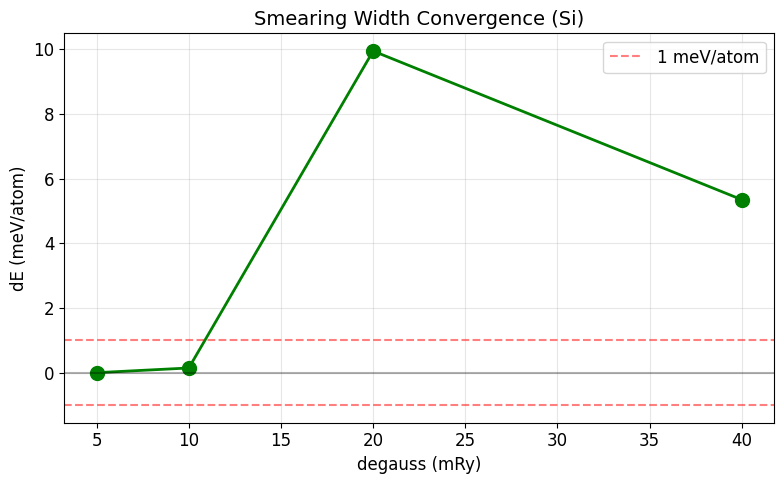

In [18]:
# Analyze smearing convergence
converged_smear_results = [r for r in smearing_results if r['converged'] and r['energy_ev_per_atom'] is not None]

if len(converged_smear_results) >= 2:
    degauss_arr = np.array([r['degauss_ry'] for r in converged_smear_results])
    energy_smear_arr = np.array([r['energy_ev_per_atom'] for r in converged_smear_results])

    # Reference: smallest degauss (most accurate)
    E_ref_smear = energy_smear_arr[0]
    delta_E_smear = (energy_smear_arr - E_ref_smear) * 1000  # meV/atom

    print(f"\nSmearing Convergence Analysis ({MATERIAL})")
    print("=" * 70)
    print(f"Reference: degauss = {degauss_arr[0]:.4f} Ry, E = {E_ref_smear:.8f} eV/atom")
    print(f"\n{'degauss (Ry)':<15} {'E (eV/atom)':<18} {'dE (meV/atom)':<18}")
    print("-" * 70)

    for i in range(len(converged_smear_results)):
        print(f"{degauss_arr[i]:<15.4f} {energy_smear_arr[i]:<18.8f} {delta_E_smear[i]:<+18.4f}")

    print("=" * 70)

    spread = np.max(np.abs(delta_E_smear))
    if spread < 1.0:
        print(f"\n→ {MATERIAL} is a semiconductor: smearing barely affects energy ({spread:.3f} meV/atom spread).")
        print("  degauss = 0.01 Ry with 'cold' smearing is a safe default.")
    else:
        print(f"\n→ Energy varies by {spread:.1f} meV/atom — smearing matters for this material!")
        print("  Use the smallest degauss that gives stable SCF convergence.")

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(degauss_arr * 1000, delta_E_smear, 'go-', markersize=10, linewidth=2)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='1 meV/atom')
    ax.axhline(y=-1, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel('degauss (mRy)', fontsize=12)
    ax.set_ylabel('dE (meV/atom)', fontsize=12)
    ax.set_title(f'Smearing Width Convergence ({MATERIAL})', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(WORK_DIR / f'{MATERIAL}_smearing_convergence.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Not enough converged smearing calculations for analysis.")

---

## 7. Combined Convergence Analysis (2D Grid)

In production work, we often need to verify that our chosen parameters are truly converged with respect to **both** ecutwfc and k-points simultaneously.

This 2D convergence table helps identify the optimal parameter set.

In [19]:
# Define 2D convergence grid (small by default)

if FAST_MODE:
    ECUTWFC_2D = [ECUTWFC_CONVERGED - 10, ECUTWFC_CONVERGED]
    KGRID_2D = [6, 8]
else:
    ECUTWFC_2D = [30, 40, 50, 60]
    KGRID_2D = [4, 6, 8, 10]

print("2D Convergence Grid Parameters")
print("=" * 50)
print(f"FAST_MODE: {FAST_MODE}")
print(f"ecutwfc values: {ECUTWFC_2D} Ry")
print(f"K-grids: {KGRID_2D}")
print(f"Total calculations: {len(ECUTWFC_2D) * len(KGRID_2D)}")

2D Convergence Grid Parameters
FAST_MODE: True
ecutwfc values: [35, 45] Ry
K-grids: [6, 8]
Total calculations: 4


In [20]:
# Run 2D convergence tests (using current structure in `atoms`)
combined_results = []
energy_grid = np.full((len(ECUTWFC_2D), len(KGRID_2D)), np.nan)
time_grid = np.zeros((len(ECUTWFC_2D), len(KGRID_2D)))

pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in elements}

print("\nRunning 2D convergence grid...")
print("=" * 80)

for i, ecutwfc in enumerate(ECUTWFC_2D):
    for j, kgrid in enumerate(KGRID_2D):
        prefix = f'conv2d_e{int(ecutwfc)}_k{kgrid}'
        input_file = WORK_DIR / f'{prefix}.in'

        input_data = {
            'control': {
                'calculation': 'scf',
                'prefix': prefix,
                'outdir': './tmp',
                'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
            },
            'system': {
                'ecutwfc': float(ecutwfc),
                'ecutrho': float(ecutwfc) * ECUTRHO_FACTOR,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.01,
            },
            'electrons': {'conv_thr': 1.0e-8},
        }

        write_espresso_in(
            input_file,
            atoms,
            input_data=input_data,
            pseudopotentials=pseudopotentials,
            kpts=(kgrid, kgrid, kgrid),
        )

        output, elapsed, converged = run_qe(input_file, nprocs=NPROCS, timeout=1800)

        energy_ry = None
        for line in output.split('\n'):
            if '!' in line and 'total energy' in line:
                match = re.search(r'=\s+([-\d.]+)\s+Ry', line)
                if match:
                    energy_ry = float(match.group(1))

        if converged and energy_ry is not None:
            energy_grid[i, j] = energy_ry

        time_grid[i, j] = elapsed

        combined_results.append({
            'ecutwfc': float(ecutwfc),
            'kgrid': int(kgrid),
            'energy_ry': energy_ry,
            'time_s': elapsed,
            'converged': converged,
        })

        status = 'OK' if (converged and energy_ry is not None) else 'FAILED'
        energy_str = f"{energy_ry:.8f}" if energy_ry is not None else 'N/A'
        print(f"ecutwfc={ecutwfc}, k={kgrid}x{kgrid}x{kgrid}: E={energy_str}, t={elapsed:.1f}s [{status}]")

print("=" * 80)
print("2D convergence grid complete!")

with open(WORK_DIR / 'combined_convergence_results.json', 'w') as f:
    json.dump(combined_results, f, indent=2)


Running 2D convergence grid...
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in conv2d_e35_k6.in


  ✓ Converged in 18.2s
ecutwfc=35, k=6x6x6: E=-22.83789138, t=18.2s [OK]
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in conv2d_e35_k8.in


  ✓ Converged in 29.9s
ecutwfc=35, k=8x8x8: E=-22.83935162, t=29.9s [OK]
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in conv2d_e45_k6.in


  ✓ Converged in 24.3s
ecutwfc=45, k=6x6x6: E=-22.83799217, t=24.3s [OK]
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in conv2d_e45_k8.in


  ✓ Converged in 29.7s
ecutwfc=45, k=8x8x8: E=-22.83945173, t=29.7s [OK]
2D convergence grid complete!


In [21]:
# Create 2D convergence table and heatmap

# Use the most converged available point as reference (last cell)
E_ref_2d = energy_grid[-1, -1]

delta_E_grid = (energy_grid - E_ref_2d) * RY_TO_MEV / n_atoms  # meV/atom

print("\n2D Convergence Table (dE in meV/atom)")
print("=" * 60)
print(f"Reference: ecutwfc={ECUTWFC_2D[-1]} Ry, k={KGRID_2D[-1]}x{KGRID_2D[-1]}x{KGRID_2D[-1]}")
print(f"Reference energy: {E_ref_2d:.8f} Ry\n")

header = f"{'ecutwfc (Ry)':<15}"
for k in KGRID_2D:
    header += f"k={k:<10}"
print(header)
print("-" * 60)

for i, ecutwfc in enumerate(ECUTWFC_2D):
    row = f"{ecutwfc:<15}"
    for j in range(len(KGRID_2D)):
        de = delta_E_grid[i, j]
        if np.isnan(de):
            row += f"{'N/A':<14}"
        else:
            marker = '*' if abs(de) < 1.0 else ' '
            row += f"{de:+.4f}{marker:<8}"
    print(row)

print("-" * 60)
print("* indicates converged (|dE| < 1 meV/atom)")


2D Convergence Table (dE in meV/atom)
Reference: ecutwfc=45 Ry, k=8x8x8
Reference energy: -22.83945173 Ry

ecutwfc (Ry)   k=6         k=8         
------------------------------------------------------------
35             +10.6148        +0.6810*       
45             +9.9292        +0.0000*       
------------------------------------------------------------
* indicates converged (|dE| < 1 meV/atom)


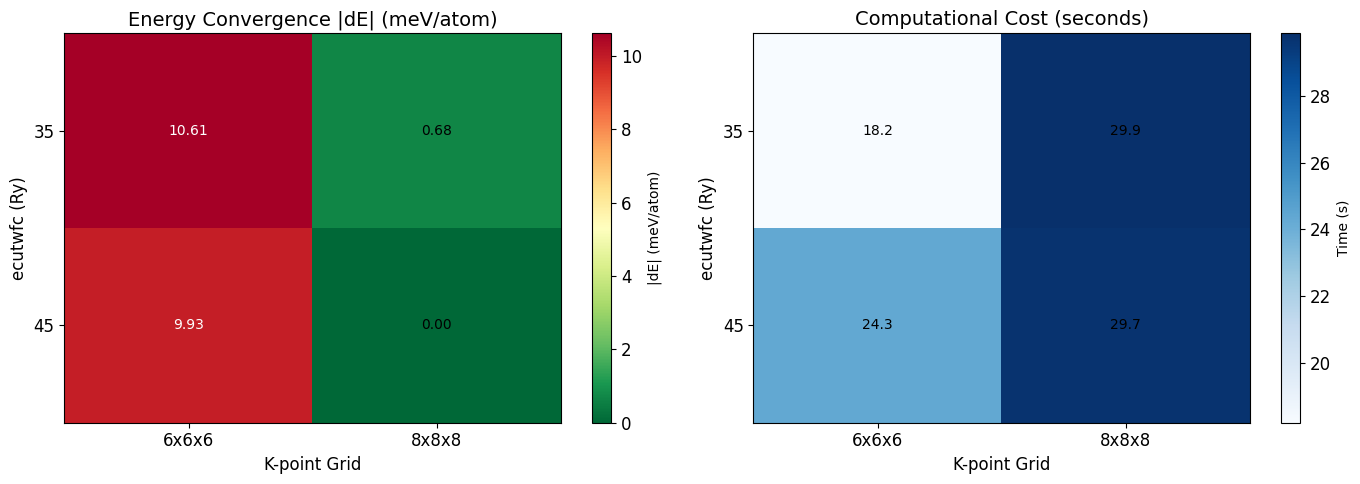

Figure saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/04_conv_Si_20260206_003758/combined_convergence_2d.png


In [22]:
# Plot 2D convergence heatmap

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Energy convergence heatmap
ax1 = axes[0]
vmax_energy = max(5, float(np.nanmax(np.abs(delta_E_grid))))
im1 = ax1.imshow(np.abs(delta_E_grid), cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=vmax_energy)
ax1.set_xticks(range(len(KGRID_2D)))
ax1.set_xticklabels([f'{k}x{k}x{k}' for k in KGRID_2D])
ax1.set_yticks(range(len(ECUTWFC_2D)))
ax1.set_yticklabels(ECUTWFC_2D)
ax1.set_xlabel('K-point Grid', fontsize=12)
ax1.set_ylabel('ecutwfc (Ry)', fontsize=12)
ax1.set_title('Energy Convergence |dE| (meV/atom)', fontsize=14)

for i in range(len(ECUTWFC_2D)):
    for j in range(len(KGRID_2D)):
        de = delta_E_grid[i, j]
        if not np.isnan(de):
            text_color = 'white' if abs(de) > vmax_energy/2 else 'black'
            ax1.text(j, i, f'{abs(de):.2f}', ha='center', va='center', color=text_color, fontsize=10)

cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('|dE| (meV/atom)', fontsize=10)

# Timing heatmap
ax2 = axes[1]
im2 = ax2.imshow(time_grid, cmap='Blues', aspect='auto')
ax2.set_xticks(range(len(KGRID_2D)))
ax2.set_xticklabels([f'{k}x{k}x{k}' for k in KGRID_2D])
ax2.set_yticks(range(len(ECUTWFC_2D)))
ax2.set_yticklabels(ECUTWFC_2D)
ax2.set_xlabel('K-point Grid', fontsize=12)
ax2.set_ylabel('ecutwfc (Ry)', fontsize=12)
ax2.set_title('Computational Cost (seconds)', fontsize=14)

for i in range(len(ECUTWFC_2D)):
    for j in range(len(KGRID_2D)):
        ax2.text(j, i, f'{time_grid[i, j]:.1f}', ha='center', va='center', color='black', fontsize=10)

cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Time (s)', fontsize=10)

plt.tight_layout()
plt.savefig(WORK_DIR / 'combined_convergence_2d.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Figure saved to: {WORK_DIR / 'combined_convergence_2d.png'}")

---

## 8. Force and Stress Convergence

### Why Forces and Stresses Need Tighter Convergence

Forces and stresses are **derivatives** of the energy:

$$F_i = -\frac{\partial E}{\partial R_i}$$

$$\sigma_{ij} = \frac{1}{V}\frac{\partial E}{\partial \epsilon_{ij}}$$

As derivatives, they are more sensitive to numerical errors than the energy itself.

### Typical Requirements

| Quantity | Energy Convergence | Force/Stress Convergence |
|----------|-------------------|-------------------------|
| Energy differences | 1 meV/atom | - |
| Geometry optimization | 1 meV/atom | < 10 meV/Angstrom |
| Phonon calculations | 0.1 meV/atom | < 1 meV/Angstrom |
| Elastic constants | 0.1 meV/atom | < 0.5 kbar |

### Why Is the Pressure ~20 kbar?

You will notice that the pressure is **not** zero (~20 kbar). This is **expected and correct**:

- We used the **experimental lattice constant** (a = 5.43 Å), not the DFT-optimized one
- PBE typically **overestimates** lattice constants by 1-2%, so the experimental volume is too small → **positive pressure**
- This non-zero pressure tells us the structure needs **relaxation** → this is exactly what **Notebook 05 (Structure Optimization)** does

### Do I Need to Redo Convergence After Lattice Optimization?

**Short answer: No** — the converged parameters from this notebook are valid for structure optimization.

**Scientific reasoning:**
- **ecutwfc** convergence depends on the **pseudopotential**, not the lattice constant. The same number of plane waves is needed regardless of small changes in cell volume.
- **K-point** convergence might change slightly if the cell volume changes dramatically (>10%), because the Brillouin zone size changes. For typical lattice optimizations (1-3% change), the k-point convergence is robust.
- **Best practice**: Converge parameters first (this notebook), then optimize the structure (NB05). If you want to be thorough, you can spot-check convergence at the optimized geometry — but it almost never changes.

In [23]:
# Analyze force and stress convergence from previous runs
print("Force and Stress Convergence Analysis")
print("=" * 70)

print("\nEcutwfc dependence of forces and stress:")
print("-" * 70)
print(f"{'ecutwfc (Ry)':<15} {'Total Force (Ry/Bohr)':<22} {'Pressure (kbar)':<18}")
print("-" * 70)

for result in ecutwfc_results:
    if result.get('converged'):
        force_str = f"{result.get('total_force'):.6f}" if result.get('total_force') is not None else 'N/A'
        press_str = f"{result.get('pressure_kbar'):.2f}" if result.get('pressure_kbar') is not None else 'N/A'
        print(f"{result.get('ecutwfc', 0):<15.0f} {force_str:<22} {press_str:<18}")

print("\nK-point dependence of forces and stress:")
print("-" * 70)
print(f"{'K-grid':<15} {'Total Force (Ry/Bohr)':<22} {'Pressure (kbar)':<18}")
print("-" * 70)

for result in kpoint_results:
    if result.get('converged'):
        k = result.get('kgrid', 0)
        force_str = f"{result.get('total_force'):.6f}" if result.get('total_force') is not None else 'N/A'
        press_str = f"{result.get('pressure_kbar'):.2f}" if result.get('pressure_kbar') is not None else 'N/A'
        print(f"{k}x{k}x{k:<11} {force_str:<22} {press_str:<18}")

print("\n" + "=" * 70)
print("Interpretation:")
print(f"- Forces ≈ 0: Expected for {MATERIAL} in the {STRUCTURE_TYPE} structure (high symmetry).")
print(f"- Pressure ≈ 20 kbar: We used the EXPERIMENTAL lattice constant (a={LATTICE_A} Å),")
print(f"  NOT the DFT-optimized one. PBE overestimates lattice constants, so the")
print(f"  experimental volume is too small → positive pressure.")
print(f"- This pressure will be minimized in Notebook 05 (Structure Optimization).")
print(f"\n→ The converged ecutwfc and k-points from this notebook are VALID for")
print(f"  structure optimization — no need to redo convergence after relaxation.")

Force and Stress Convergence Analysis

Ecutwfc dependence of forces and stress:
----------------------------------------------------------------------
ecutwfc (Ry)    Total Force (Ry/Bohr)  Pressure (kbar)   
----------------------------------------------------------------------
20              0.000000               19.30             
30              0.000000               20.76             
40              0.000000               20.88             
50              0.000000               20.91             
60              0.000000               20.96             

K-point dependence of forces and stress:
----------------------------------------------------------------------
K-grid          Total Force (Ry/Bohr)  Pressure (kbar)   
----------------------------------------------------------------------
4x4x4           0.000000               26.53             
6x6x6           0.000000               20.84             
8x8x8           0.000000               20.21             
10x10x10      

---

## 9. Convergence Study Summary

Let's compile all our findings into a comprehensive summary.

In [24]:
# Create a concise summary (works with FAST_MODE and the variables created above)

print("\n" + "=" * 80)
print(f"CONVERGENCE STUDY - SUMMARY ({MATERIAL})")
print("=" * 80)

print(f"Functional: {FUNCTIONAL}")
print(f"ecutwfc converged (first ΔE<1 meV/atom): {ecutwfc_converged} Ry")
print(f"Recommended ecutwfc (margin): {ecutwfc_converged + 5} Ry")

print(f"k-grid converged (first ΔE<1 meV/atom): {kgrid_converged}x{kgrid_converged}x{kgrid_converged}")
print(f"Recommended k-grid (margin): {kgrid_converged + 2}x{kgrid_converged + 2}x{kgrid_converged + 2}")

recommended_ecutwfc = ecutwfc_converged + 5
recommended_kgrid = kgrid_converged + 2

print("\nRecommended production parameters:")
print(f"  ecutwfc = {recommended_ecutwfc} Ry")
print(f"  ecutrho = {recommended_ecutwfc * ECUTRHO_FACTOR} Ry")
print(f"  k-points = {recommended_kgrid}x{recommended_kgrid}x{recommended_kgrid}")

print("=" * 80)


CONVERGENCE STUDY - SUMMARY (Si)
Functional: PBE
ecutwfc converged (first ΔE<1 meV/atom): 40 Ry
Recommended ecutwfc (margin): 45 Ry
k-grid converged (first ΔE<1 meV/atom): 12x12x12
Recommended k-grid (margin): 14x14x14

Recommended production parameters:
  ecutwfc = 45 Ry
  ecutrho = 360 Ry
  k-points = 14x14x14


---

## 10. Save Converged Parameters for Subsequent Calculations

In [25]:
# Save converged parameters to JSON file (workshop-friendly)

converged_parameters = {
    'material': MATERIAL,
    'functional': FUNCTIONAL,
    'convergence_criteria': {
        'energy_mev_per_atom': 1.0,
    },
    'ecutwfc': {
        'converged': float(ecutwfc_converged),
        'recommended': float(recommended_ecutwfc),
        'unit': 'Ry',
    },
    'ecutrho': {
        'factor': ECUTRHO_FACTOR,
        'recommended': float(recommended_ecutwfc * ECUTRHO_FACTOR),
        'unit': 'Ry',
    },
    'kpoints': {
        'converged': int(kgrid_converged),
        'recommended': int(recommended_kgrid),
        'grid': [int(recommended_kgrid)] * 3,
    },
    'metadata': {
        'date': time.strftime('%Y-%m-%d'),
        'notebook': '04_Convergence_Testing.ipynb',
    },
}

params_file = WORKSHOP_ROOT / 'converged_parameters.json'
with open(params_file, 'w') as f:
    json.dump(converged_parameters, f, indent=2)

print("Converged parameters saved to:")
print(f"  {params_file}")
print("\nFile contents:")
print(json.dumps(converged_parameters, indent=2))

Converged parameters saved to:
  /home/niel/git/DFT_Tutorial/qe_workshop_complete/converged_parameters.json

File contents:
{
  "material": "Si",
  "functional": "PBE",
  "convergence_criteria": {
    "energy_mev_per_atom": 1.0
  },
  "ecutwfc": {
    "converged": 40.0,
    "recommended": 45.0,
    "unit": "Ry"
  },
  "ecutrho": {
    "factor": 8,
    "recommended": 360.0,
    "unit": "Ry"
  },
  "kpoints": {
    "converged": 12,
    "recommended": 14,
    "grid": [
      14,
      14,
      14
    ]
  },
  "metadata": {
    "date": "2026-02-06",
    "notebook": "04_Convergence_Testing.ipynb"
  }
}


In [26]:
# Demonstrate loading and using converged parameters (workshop-friendly)

def load_converged_parameters(filepath: Path) -> Dict:
    with open(filepath, 'r') as f:
        params = json.load(f)
    return params


def generate_production_input(params: Dict, prefix: str, pseudo_dir: Path) -> str:
    kgrid = params['kpoints']['grid']

    # Use defaults if optional blocks are not present
    conv_thr = 1.0e-8
    degauss = 0.01
    smearing = 'cold'

    return generate_scf_input(
        prefix=prefix,
        ecutwfc=params['ecutwfc']['recommended'],
        ecutrho=params['ecutrho']['recommended'],
        kpoints=tuple(kgrid),
        pseudo_dir=pseudo_dir,
        conv_thr=conv_thr,
        degauss=degauss,
        smearing=smearing,
    )


loaded_params = load_converged_parameters(params_file)
production_input = generate_production_input(loaded_params, f'{MATERIAL.lower()}_production', PSEUDO_DIR)

print("Production-Quality Input File:")
print("=" * 60)
print(production_input)

Production-Quality Input File:
&CONTROL
  calculation = 'scf'
  prefix = 'si_production'
  outdir = './tmp'
  pseudo_dir = '../../pseudopotentials/PBE'
  verbosity = 'high'
  tprnfor = .true.
  tstress = .true.
/
&SYSTEM
  ibrav = 0
  nat = 2
  ntyp = 1
  ecutwfc = 45.0
  ecutrho = 360.0
  occupations = 'smearing'
  smearing = 'cold'
  degauss = 0.01
/
&ELECTRONS
  conv_thr = 1e-08
/
ATOMIC_SPECIES
 Si 28.085000 Si.pbe-n-rrkjus_psl.1.0.0.UPF
ATOMIC_POSITIONS angstrom
 Si 0.0000000000 0.0000000000 0.0000000000
 Si 1.3575000000 1.3575000000 1.3575000000
K_POINTS automatic
 14 14 14 0 0 0
CELL_PARAMETERS angstrom
 0.000000000000 2.715000000000 2.715000000000
 2.715000000000 0.000000000000 2.715000000000
 2.715000000000 2.715000000000 0.000000000000



---

## 11. Key Takeaways

### Summary of This Notebook

1. **Convergence testing is mandatory** - Never skip this step
2. **Test systematically** - One parameter at a time, then verify with 2D grid
3. **Use appropriate thresholds** - 1 meV/atom for most properties, tighter for forces/phonons
4. **Document your tests** - Save results for reproducibility
5. **Add safety margins** - Production calculations should use slightly higher values

### Common Mistakes to Avoid

| Mistake | Why It's Bad | Solution |
|---------|-------------|----------|
| Using literature values blindly | Different pseudopotentials need different cutoffs | Always test yourself |
| Converging ecutwfc but not k-points | Both affect accuracy | Test both, ideally 2D grid |
| Using the same parameters for all properties | Forces need tighter convergence | Adjust for property of interest |
| Not saving convergence data | Can't reproduce or verify | Save to JSON files |

### Parameter Guidelines

| Pseudopotential Type | Typical ecutwfc | ecutrho Factor |
|---------------------|-----------------|----------------|
| Norm-conserving | 60-100 Ry | 4x |
| Ultrasoft | 30-50 Ry | 8-10x |
| PAW | 30-60 Ry | 8-12x |

### Next Steps

With converged parameters in hand, you can now proceed to:
- Lattice parameter optimization
- Band structure calculations
- Density of states
- Phonon calculations
- And any other property calculations

**Always load and use your converged_parameters.json for production calculations!**